## Chest X-Ray Image Generation Model

Based on code from this ACGAN implementation:
https://github.com/clvrai/ACGAN-PyTorch/tree/master

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import cv2
import matplotlib.pyplot as plt
from torch.autograd import Variable

import csv
import time
import torchvision
from torch.autograd import Variable
from collections import defaultdict
import torchvision.models as models
from scipy import linalg
from sklearn.metrics import accuracy_score

### Load the data

In [ ]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
path = path + "/chest_xray/"

train_path = path + "train/"
test_path = path + "test/"
val_path = path + "val/"

In [ ]:
# check path

!ls $path
# !ls $train_path/NORMAL
!ls $test_path
!ls $val_path

chest_xray  __MACOSX  test  train  val
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


In [ ]:
# check original image sizes

img_size_check = cv2.imread(train_path + 'NORMAL/NORMAL2-IM-0389-0001.jpeg')

print(img_size_check.shape)

(1136, 1484, 3)


In [ ]:
# Create logs directory if it doesn't exist
os.makedirs("logs", exist_ok=True)

# Initialize metrics dictionary
metrics = defaultdict(list)

In [ ]:
# Setup CSV logger
class MetricsLogger:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.headers = None
        self.file = None
        self.writer = None

    def log(self, metrics_dict, step):
        # Add step/epoch to metrics
        full_metrics = {'step': step, **metrics_dict}

        # Initialize CSV file if it doesn't exist
        if self.headers is None:
            self.headers = list(full_metrics.keys())
            self.file = open(self.csv_path, 'w', newline='')
            self.writer = csv.DictWriter(self.file, fieldnames=self.headers)
            self.writer.writeheader()

        # Write metrics to CSV
        self.writer.writerow(full_metrics)
        self.file.flush()

    def close(self):
        if self.file is not None:
            self.file.close()

In [ ]:
# Initialize loggers
epoch_logger = MetricsLogger('logs/epoch_metrics.csv')
batch_logger = MetricsLogger('logs/batch_metrics.csv')

In [ ]:
# FID Score calculation helper
def calculate_fid(real_images, fake_images, batch_size=32):
    """Calculate FID score between real and generated images"""
    inception = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    def get_activations(images, model):
        with torch.no_grad():
            pred = model(images)[0]
        return pred.view(pred.size(0), -1).cpu().numpy()

    # Get activations for real images
    real_activations = get_activations(real_images, inception)

    # Get activations for fake images
    fake_activations = get_activations(fake_images, inception)

    # Calculate mean and covariance
    mu1, sigma1 = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = fake_activations.mean(axis=0), np.cov(fake_activations, rowvar=False)

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [ ]:
# Inception Score calculation helper
def calculate_inception_score(fake_images, n_split=10, batch_size=32):
    """Calculate Inception Score for generated images"""
    inception = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    def get_pred(x):
        with torch.no_grad():
            pred = torch.nn.functional.softmax(inception(x)[0], dim=1)
        return pred.cpu().numpy()

    # Get predictions
    preds = []
    n_batches = len(fake_images) // batch_size
    for i in range(n_batches):
        batch = fake_images[i * batch_size: (i + 1) * batch_size]
        preds.append(get_pred(batch))
    preds = np.concatenate(preds, axis=0)

    # Calculate Inception Score
    scores = []
    for i in range(n_split):
        part = preds[i * len(preds) // n_split: (i + 1) * len(preds) // n_split, :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

In [ ]:
# Classification accuracy helper
def calculate_accuracy(pred_labels, true_labels):
    """Calculate classification accuracy"""
    pred_classes = torch.argmax(pred_labels, dim=1).cpu()
    true_classes = true_labels.cpu()
    return accuracy_score(true_classes, pred_classes)

# Gradient norm helper
def get_gradient_norm(model):
    """Calculate gradient norm for a model"""
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

## Baseline Architecture

The architecture is heavily based on this PyTorch implementation of an ACGAN:
https://github.com/clvrai/ACGAN-PyTorch/blob/master/network.py

In [ ]:
# Hyperparameters
image_size = 128 # planning on increasing to 128 - Idris
batch_size = 64
n_classes = 2
lr_g = 4e-5
lr_d = 1e-5
beta1, beta2 = 0.5, 0.999
latent_dim = 100
n_epochs = 100
sample_interval = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

class Generator(nn.Module):
    def __init__(self, latent_dim=100, n_classes=2, img_channels=1, feature_maps=64):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        input_dim = latent_dim + n_classes
        ds_factor = image_size // 16 # change the left number to image size
        proj_dim = feature_maps * 8 * ds_factor * ds_factor

        self.net = nn.Sequential(
            # project and reshape
            nn.Linear(input_dim, proj_dim),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU(True),
            nn.Unflatten(1, (feature_maps*8, ds_factor, ds_factor)),

            # upsampling blocks
            nn.ConvTranspose2d(feature_maps*8, feature_maps*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps*4, feature_maps*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps*2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # final grayscale output
            nn.ConvTranspose2d(feature_maps, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # embed labels and concatenate
        c = self.label_emb(labels)
        x = torch.cat([noise, c], dim=1)
        return self.net(x)

In [ ]:
# adding spectral norm
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self, n_classes=2, img_channels=1, feature_maps=64):
        super().__init__()

        self.shared = nn.Sequential(
            spectral_norm(nn.Conv2d(img_channels, feature_maps, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(feature_maps, feature_maps*2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_maps*2),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(feature_maps*2, feature_maps*4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_maps*4),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(feature_maps*4, feature_maps*8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_maps*8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        ds_factor = image_size // 16 # change the left number to image size
        feat_dim = feature_maps * 8 * ds_factor * ds_factor

        # real/fake output
        self.adv_layer = nn.Sequential(
            nn.Flatten(),
            spectral_norm(nn.Linear(feat_dim, 1)),
            nn.Sigmoid(),
        )
        # auxiliary classifier
        self.aux_layer = nn.Sequential(
            spectral_norm(nn.Linear(feat_dim, n_classes)),
            nn.Softmax(dim=1),
        )

    def forward(self, img):
        feat = self.shared(img)
        flat = feat.view(feat.size(0), -1)
        validity = self.adv_layer(flat)
        label = self.aux_layer(flat)
        return validity, label

In [ ]:
generator = Generator(latent_dim, n_classes, 3).to(device)
discriminator = Discriminator(n_classes, 3).to(device)

# Loss functions & Optimizers

adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

In [ ]:
# Dataloading
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
dataset = dset.ImageFolder(root=train_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

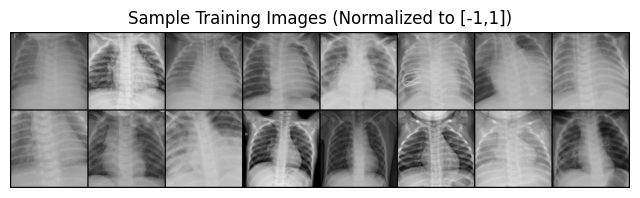

In [ ]:
trial_data = iter(dataloader)
img_preview, lbl_preview = next(trial_data)

grid = vutils.make_grid(img_preview[:16], nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(8, 4))
# Convert from CHW to HWC and plot
plt.imshow(grid.permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
plt.title('Sample Training Images (Normalized to [-1,1])')
plt.axis('off')
plt.show()

### Training Loop

In [ ]:
# make a directory if needed to save images
os.makedirs("images_kp", exist_ok=True)
# need to change the path so that it actually saves in our drive - Idris

In [ ]:
G_losses = []
D_losses = []
# iters = 0

for epoch in range(n_epochs):
    epoch_metrics = defaultdict(float)
    batch_count = 0

    start_time = time.time()

    for batch_idx, (imgs, labels) in enumerate(dataloader):
        batch_count += 1
        batch_size = imgs.size(0)

        # label smoothing: using 0.9 instead of 1.0 for the real labels
        real_lbl = torch.ones(batch_size, 1).to(device) * 0.9
        fake_lbl = torch.zeros(batch_size, 1).to(device) + 0.1

        imgs = imgs.to(device)
        labels = labels.to(device)

        # Train generator
        optimizer_G.zero_grad()

        noise = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
        gen_imgs = generator(noise, gen_labels)

        validity, pred_label = discriminator(gen_imgs)
        g_adv_loss = adversarial_loss(validity, real_lbl)
        g_aux_loss = auxiliary_loss(pred_label, gen_labels)
        g_loss = g_adv_loss + g_aux_loss
        g_loss.backward()
        optimizer_G.step()

        # Calculate generator gradient norm
        g_grad_norm = get_gradient_norm(generator)

        # Train discriminator
        optimizer_D.zero_grad()

        # Real images
        real_val, real_pred_label = discriminator(imgs)
        d_real_adv_loss = adversarial_loss(real_val, real_lbl)
        d_real_aux_loss = auxiliary_loss(real_pred_label, labels)
        d_real_loss = d_real_adv_loss + d_real_aux_loss

        # Fake images
        fake_val, fake_pred_label = discriminator(gen_imgs.detach())
        d_fake_adv_loss = adversarial_loss(fake_val, fake_lbl)
        d_fake_loss = d_fake_adv_loss

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Calculate discriminator gradient norm
        d_grad_norm = get_gradient_norm(discriminator)

        # Calculate classification accuracy
        real_acc = calculate_accuracy(real_pred_label, labels)
        fake_acc = calculate_accuracy(fake_pred_label, gen_labels)

        # Log batch metrics
        batch_metrics = {
            'epoch': epoch,
            'batch': batch_idx,
            'g_loss': g_loss.item(),
            'g_adv_loss': g_adv_loss.item(),
            'g_aux_loss': g_aux_loss.item(),
            'd_loss': d_loss.item(),
            'd_real_loss': d_real_loss.item(),
            'd_fake_loss': d_fake_loss.item(),
            'd_real_adv_loss': d_real_adv_loss.item(),
            'd_real_aux_loss': d_real_aux_loss.item(),
            'd_fake_adv_loss': d_fake_adv_loss.item(),
            'real_accuracy': real_acc,
            'fake_accuracy': fake_acc,
            'g_grad_norm': g_grad_norm,
            'd_grad_norm': d_grad_norm
        }

        # Log every 10 batches to avoid excessive file I/O
        if batch_idx % 10 == 0:
            batch_logger.log(batch_metrics, epoch * len(dataloader) + batch_idx)

        # Accumulate metrics for epoch average
        for key, value in batch_metrics.items():
            if key not in ['epoch', 'batch']:
                epoch_metrics[key] += value

    # Calculate epoch average metrics
    for key in epoch_metrics:
        epoch_metrics[key] /= batch_count

    # Calculate FID and IS once per epoch (computationally expensive)
    if epoch % 10 == 0 or epoch == n_epochs - 1:  # Every 10 epochs or last epoch
        # Generate a batch of images for evaluation
        eval_noise = torch.randn(100, latent_dim).to(device)
        eval_labels = torch.randint(0, n_classes, (100,)).to(device)
        eval_gen_imgs = generator(eval_noise, eval_labels)

        # Get a batch of real images for comparison
        real_imgs_sample = next(iter(dataloader))[0].to(device)

        # Calculate FID
        try:
            fid_score = calculate_fid(real_imgs_sample, eval_gen_imgs)
            epoch_metrics['fid_score'] = fid_score
        except Exception as e:
            print(f"Error calculating FID: {e}")
            epoch_metrics['fid_score'] = -1

        # Calculate Inception Score
        try:
            is_mean, is_std = calculate_inception_score(eval_gen_imgs)
            epoch_metrics['inception_score'] = is_mean
            epoch_metrics['inception_score_std'] = is_std
        except Exception as e:
            print(f"Error calculating Inception Score: {e}")
            epoch_metrics['inception_score'] = -1
            epoch_metrics['inception_score_std'] = -1

    # Add timing information
    epoch_time = time.time() - start_time
    epoch_metrics['epoch_time'] = epoch_time

    # Log epoch metrics
    epoch_logger.log(epoch_metrics, epoch)

    # Print progress
    print(f"[Epoch {epoch}/{n_epochs}] "
          f"D loss: {epoch_metrics['d_loss']:.4f}, G loss: {epoch_metrics['g_loss']:.4f}, "
          f"Real Acc: {epoch_metrics['real_accuracy']:.4f}, FID: {epoch_metrics.get('fid_score', 'N/A')}")

    # Save sample images
    z = torch.randn(n_classes, latent_dim).to(device)
    labels_sample = torch.arange(0, n_classes).to(device)
    sample_imgs = generator(z, labels_sample)
    vutils.save_image(
        sample_imgs.data,
        f"images_kp/epoch{epoch}.png",
        nrow=n_classes,
        normalize=True,
        value_range=(-1,1)
    )

    # Save model checkpoints periodically
    if epoch % 20 == 0 or epoch == n_epochs - 1:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
        }, f"logs/checkpoint_epoch_{epoch}.pt")

# Close loggers
epoch_logger.close()
batch_logger.close()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 234MB/s] 


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 0/100] D loss: 0.6489, G loss: 1.9817, Real Acc: 0.9135, FID: -1
[Epoch 1/100] D loss: 0.5497, G loss: 2.4672, Real Acc: 0.9585, FID: N/A
[Epoch 2/100] D loss: 0.5345, G loss: 2.5911, Real Acc: 0.9636, FID: N/A
[Epoch 3/100] D loss: 0.5295, G loss: 2.6916, Real Acc: 0.9697, FID: N/A
[Epoch 4/100] D loss: 0.5226, G loss: 2.7748, Real Acc: 0.9748, FID: N/A
[Epoch 5/100] D loss: 0.5181, G loss: 2.7229, Real Acc: 0.9737, FID: N/A
[Epoch 6/100] D loss: 0.5136, G loss: 2.7162, Real Acc: 0.9773, FID: N/A
[Epoch 7/100] D loss: 0.5098, G loss: 2.7218, Real Acc: 0.9806, FID: N/A
[Epoch 8/100] D loss: 0.5069, G loss: 2.7241, Real Acc: 0.9817, FID: N/A
[Epoch 9/100] D loss: 0.5056, G loss: 2.7174, Real Acc: 0.9829, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 10/100] D loss: 0.5042, G loss: 2.7030, Real Acc: 0.9844, FID: -1
[Epoch 11/100] D loss: 0.5061, G loss: 2.6347, Real Acc: 0.9863, FID: N/A
[Epoch 12/100] D loss: 0.5064, G loss: 2.5274, Real Acc: 0.9857, FID: N/A
[Epoch 13/100] D loss: 0.5121, G loss: 2.5354, Real Acc: 0.9872, FID: N/A
[Epoch 14/100] D loss: 0.5082, G loss: 2.4951, Real Acc: 0.9880, FID: N/A
[Epoch 15/100] D loss: 0.5040, G loss: 2.5067, Real Acc: 0.9882, FID: N/A
[Epoch 16/100] D loss: 0.5034, G loss: 2.5118, Real Acc: 0.9897, FID: N/A
[Epoch 17/100] D loss: 0.5052, G loss: 2.5250, Real Acc: 0.9893, FID: N/A
[Epoch 18/100] D loss: 0.5227, G loss: 2.6078, Real Acc: 0.9901, FID: N/A
[Epoch 19/100] D loss: 0.5374, G loss: 2.4543, Real Acc: 0.9907, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 20/100] D loss: 0.5469, G loss: 2.2646, Real Acc: 0.9907, FID: -1
[Epoch 21/100] D loss: 0.5400, G loss: 2.1661, Real Acc: 0.9905, FID: N/A
[Epoch 22/100] D loss: 0.5384, G loss: 2.0843, Real Acc: 0.9914, FID: N/A
[Epoch 23/100] D loss: 0.5404, G loss: 2.0850, Real Acc: 0.9901, FID: N/A
[Epoch 24/100] D loss: 0.5384, G loss: 2.0982, Real Acc: 0.9920, FID: N/A
[Epoch 25/100] D loss: 0.5382, G loss: 2.1027, Real Acc: 0.9924, FID: N/A
[Epoch 26/100] D loss: 0.5411, G loss: 2.0878, Real Acc: 0.9926, FID: N/A
[Epoch 27/100] D loss: 0.5322, G loss: 2.1063, Real Acc: 0.9935, FID: N/A
[Epoch 28/100] D loss: 0.5333, G loss: 2.1272, Real Acc: 0.9941, FID: N/A
[Epoch 29/100] D loss: 0.5295, G loss: 2.1538, Real Acc: 0.9937, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 30/100] D loss: 0.5256, G loss: 2.1688, Real Acc: 0.9933, FID: -1
[Epoch 31/100] D loss: 0.5380, G loss: 2.1916, Real Acc: 0.9943, FID: N/A
[Epoch 32/100] D loss: 0.5355, G loss: 2.1479, Real Acc: 0.9943, FID: N/A
[Epoch 33/100] D loss: 0.5275, G loss: 2.1623, Real Acc: 0.9945, FID: N/A
[Epoch 34/100] D loss: 0.5401, G loss: 2.1130, Real Acc: 0.9949, FID: N/A
[Epoch 35/100] D loss: 0.5414, G loss: 2.1456, Real Acc: 0.9950, FID: N/A
[Epoch 36/100] D loss: 0.5402, G loss: 2.0838, Real Acc: 0.9960, FID: N/A
[Epoch 37/100] D loss: 0.5361, G loss: 2.1444, Real Acc: 0.9954, FID: N/A
[Epoch 38/100] D loss: 0.5335, G loss: 2.1071, Real Acc: 0.9964, FID: N/A
[Epoch 39/100] D loss: 0.5442, G loss: 2.1333, Real Acc: 0.9960, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 40/100] D loss: 0.5430, G loss: 2.1354, Real Acc: 0.9964, FID: -1
[Epoch 41/100] D loss: 0.5341, G loss: 2.0792, Real Acc: 0.9964, FID: N/A
[Epoch 42/100] D loss: 0.5512, G loss: 2.1189, Real Acc: 0.9966, FID: N/A
[Epoch 43/100] D loss: 0.5416, G loss: 2.1519, Real Acc: 0.9966, FID: N/A
[Epoch 44/100] D loss: 0.5559, G loss: 2.1394, Real Acc: 0.9968, FID: N/A
[Epoch 45/100] D loss: 0.5472, G loss: 2.1346, Real Acc: 0.9966, FID: N/A
[Epoch 46/100] D loss: 0.5490, G loss: 2.1531, Real Acc: 0.9968, FID: N/A
[Epoch 47/100] D loss: 0.5447, G loss: 2.1199, Real Acc: 0.9968, FID: N/A
[Epoch 48/100] D loss: 0.5433, G loss: 2.1058, Real Acc: 0.9970, FID: N/A
[Epoch 49/100] D loss: 0.5507, G loss: 2.1820, Real Acc: 0.9971, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 50/100] D loss: 0.5481, G loss: 2.1125, Real Acc: 0.9970, FID: -1
[Epoch 51/100] D loss: 0.5408, G loss: 2.1102, Real Acc: 0.9971, FID: N/A
[Epoch 52/100] D loss: 0.5447, G loss: 2.1379, Real Acc: 0.9971, FID: N/A
[Epoch 53/100] D loss: 0.5435, G loss: 2.1120, Real Acc: 0.9970, FID: N/A
[Epoch 54/100] D loss: 0.5504, G loss: 2.1611, Real Acc: 0.9971, FID: N/A
[Epoch 55/100] D loss: 0.5405, G loss: 2.1369, Real Acc: 0.9971, FID: N/A
[Epoch 56/100] D loss: 0.5416, G loss: 2.1183, Real Acc: 0.9975, FID: N/A
[Epoch 57/100] D loss: 0.5462, G loss: 2.1179, Real Acc: 0.9975, FID: N/A
[Epoch 58/100] D loss: 0.5471, G loss: 2.1142, Real Acc: 0.9975, FID: N/A
[Epoch 59/100] D loss: 0.5457, G loss: 2.1258, Real Acc: 0.9975, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 60/100] D loss: 0.5357, G loss: 2.1314, Real Acc: 0.9975, FID: -1
[Epoch 61/100] D loss: 0.5438, G loss: 2.0923, Real Acc: 0.9975, FID: N/A
[Epoch 62/100] D loss: 0.5499, G loss: 2.1380, Real Acc: 0.9977, FID: N/A
[Epoch 63/100] D loss: 0.5452, G loss: 2.1167, Real Acc: 0.9979, FID: N/A
[Epoch 64/100] D loss: 0.5347, G loss: 2.1143, Real Acc: 0.9979, FID: N/A
[Epoch 65/100] D loss: 0.5349, G loss: 2.1522, Real Acc: 0.9979, FID: N/A
[Epoch 66/100] D loss: 0.5428, G loss: 2.0984, Real Acc: 0.9979, FID: N/A
[Epoch 67/100] D loss: 0.5390, G loss: 2.1386, Real Acc: 0.9979, FID: N/A
[Epoch 68/100] D loss: 0.5366, G loss: 2.1168, Real Acc: 0.9979, FID: N/A
[Epoch 69/100] D loss: 0.5419, G loss: 2.1361, Real Acc: 0.9979, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 70/100] D loss: 0.5369, G loss: 2.1323, Real Acc: 0.9979, FID: -1
[Epoch 71/100] D loss: 0.5384, G loss: 2.1176, Real Acc: 0.9979, FID: N/A
[Epoch 72/100] D loss: 0.5388, G loss: 2.1528, Real Acc: 0.9979, FID: N/A
[Epoch 73/100] D loss: 0.5443, G loss: 2.1504, Real Acc: 0.9979, FID: N/A
[Epoch 74/100] D loss: 0.5361, G loss: 2.0929, Real Acc: 0.9981, FID: N/A
[Epoch 75/100] D loss: 0.5402, G loss: 2.1100, Real Acc: 0.9983, FID: N/A
[Epoch 76/100] D loss: 0.5364, G loss: 2.1398, Real Acc: 0.9981, FID: N/A
[Epoch 77/100] D loss: 0.5361, G loss: 2.1126, Real Acc: 0.9983, FID: N/A
[Epoch 78/100] D loss: 0.5390, G loss: 2.1303, Real Acc: 0.9983, FID: N/A
[Epoch 79/100] D loss: 0.5395, G loss: 2.1213, Real Acc: 0.9985, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 80/100] D loss: 0.5385, G loss: 2.1162, Real Acc: 0.9985, FID: -1
[Epoch 81/100] D loss: 0.5376, G loss: 2.1321, Real Acc: 0.9985, FID: N/A
[Epoch 82/100] D loss: 0.5371, G loss: 2.1435, Real Acc: 0.9985, FID: N/A
[Epoch 83/100] D loss: 0.5333, G loss: 2.1693, Real Acc: 0.9985, FID: N/A
[Epoch 84/100] D loss: 0.5395, G loss: 2.1534, Real Acc: 0.9985, FID: N/A
[Epoch 85/100] D loss: 0.5375, G loss: 2.1418, Real Acc: 0.9985, FID: N/A
[Epoch 86/100] D loss: 0.5360, G loss: 2.1389, Real Acc: 0.9985, FID: N/A
[Epoch 87/100] D loss: 0.5348, G loss: 2.2175, Real Acc: 0.9985, FID: N/A
[Epoch 88/100] D loss: 0.5346, G loss: 2.1432, Real Acc: 0.9987, FID: N/A
[Epoch 89/100] D loss: 0.5402, G loss: 2.1401, Real Acc: 0.9987, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 90/100] D loss: 0.5357, G loss: 2.1057, Real Acc: 0.9987, FID: -1
[Epoch 91/100] D loss: 0.5406, G loss: 2.1524, Real Acc: 0.9987, FID: N/A
[Epoch 92/100] D loss: 0.5346, G loss: 2.1856, Real Acc: 0.9987, FID: N/A
[Epoch 93/100] D loss: 0.5336, G loss: 2.1643, Real Acc: 0.9987, FID: N/A
[Epoch 94/100] D loss: 0.5470, G loss: 2.1990, Real Acc: 0.9987, FID: N/A
[Epoch 95/100] D loss: 0.5335, G loss: 2.1521, Real Acc: 0.9987, FID: N/A
[Epoch 96/100] D loss: 0.5349, G loss: 2.1534, Real Acc: 0.9987, FID: N/A
[Epoch 97/100] D loss: 0.5310, G loss: 2.1510, Real Acc: 0.9987, FID: N/A
[Epoch 98/100] D loss: 0.5309, G loss: 2.1648, Real Acc: 0.9987, FID: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error calculating FID: Non-matrix input to matrix function.
Error calculating Inception Score: Dimension out of range (expected to be in range of [-1, 0], but got 1)
[Epoch 99/100] D loss: 0.5316, G loss: 2.1894, Real Acc: 0.9987, FID: -1


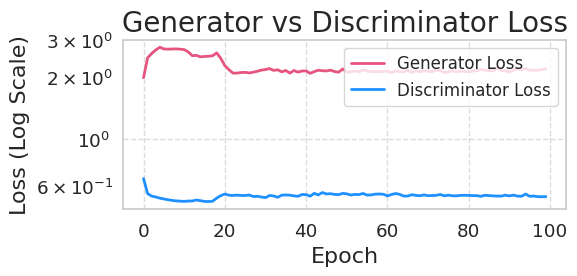

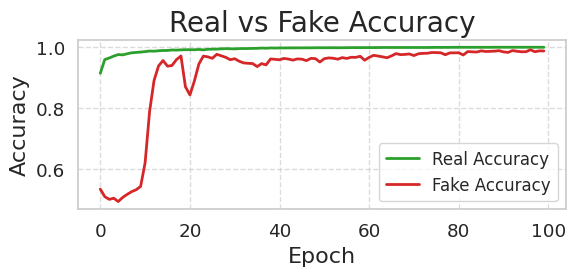

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_theme(style="whitegrid", font_scale=1.2, font="sans-serif")

# Load data
metrics_df = pd.read_csv('logs/epoch_metrics.csv')

# Plot: Generator vs Discriminator Loss
plt.figure(figsize=(6, 3))
plt.plot(metrics_df['step'], metrics_df['g_loss'], label='Generator Loss', color='#e75480', linewidth=2)
plt.plot(metrics_df['step'], metrics_df['d_loss'], label='Discriminator Loss', color='#1e90ff', linewidth=2)
plt.xscale('linear')
plt.yscale('log')  # Log scale to manage gap
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.ylabel('Loss (Log Scale)', fontsize=16, fontfamily='sans-serif')
plt.title('Generator vs Discriminator Loss', fontsize=20, fontfamily='sans-serif')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot: Real vs Fake Accuracy
plt.figure(figsize=(6, 3))
plt.plot(metrics_df['step'], metrics_df['real_accuracy'], label='Real Accuracy', color='#2ca02c', linewidth=2)
plt.plot(metrics_df['step'], metrics_df['fake_accuracy'], label='Fake Accuracy', color='#d62728', linewidth=2)
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.ylabel('Accuracy', fontsize=16, fontfamily='sans-serif')
plt.title('Real vs Fake Accuracy', fontsize=20, fontfamily='sans-serif')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
!cp /content/logs/checkpoint_epoch_99.pt /content/drive/MyDrive/MSCS/DL/DL_medGAN_project/logs/medganx/

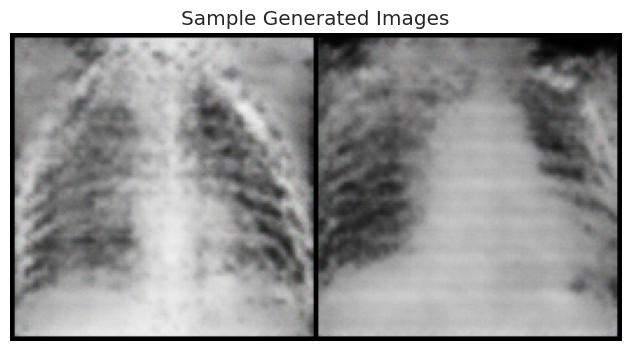

In [ ]:
z = torch.randn(n_classes, latent_dim).to(device)
labels_sample = torch.arange(0, n_classes).to(device)
sample_imgs = generator(z, labels_sample)

grid = vutils.make_grid(sample_imgs, nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(8, 4))
# Convert from CHW to HWC and plot
plt.imshow(grid.permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
plt.title('Sample Generated Images')
plt.axis('off')
plt.show()

In [ ]:
batch_metrics_a = "/content/drive/MyDrive/MSCS/DL/DL_medGAN_project/logs/baseline/batch_metrics.csv"
epoch_metrics_a = "/content/drive/MyDrive/MSCS/DL/DL_medGAN_project/logs/baseline/epoch_metrics.csv"

batch_metrics_m = "/content/drive/MyDrive/MSCS/DL/DL_medGAN_project/logs/medganx/batch_metrics.csv"
epoch_metrics_m = "/content/drive/MyDrive/MSCS/DL/DL_medGAN_project/logs/medganx/epoch_metrics.csv"

In [ ]:
batch_df = pd.read_csv(batch_metrics)
batch_df.columns

Index(['step', 'epoch', 'batch', 'g_loss', 'g_adv_loss', 'g_aux_loss',
       'd_loss', 'd_real_loss', 'd_fake_loss', 'd_real_adv_loss',
       'd_real_aux_loss', 'd_fake_adv_loss', 'real_accuracy', 'fake_accuracy',
       'g_grad_norm', 'd_grad_norm'],
      dtype='object')

In [ ]:
epoch_df = pd.read_csv(epoch_metrics)
epoch_df.columns

Index(['step', 'g_loss', 'g_adv_loss', 'g_aux_loss', 'd_loss', 'd_real_loss',
       'd_fake_loss', 'd_real_adv_loss', 'd_real_aux_loss', 'd_fake_adv_loss',
       'real_accuracy', 'fake_accuracy', 'g_grad_norm', 'd_grad_norm',
       'fid_score', 'inception_score', 'inception_score_std', 'epoch_time'],
      dtype='object')

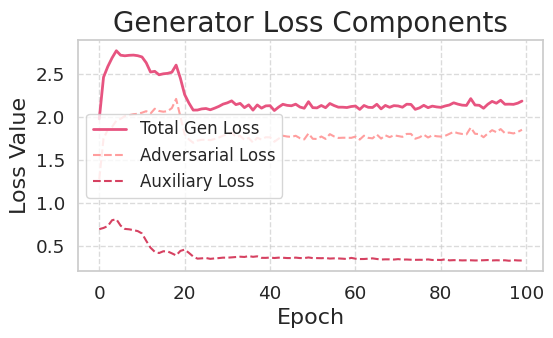

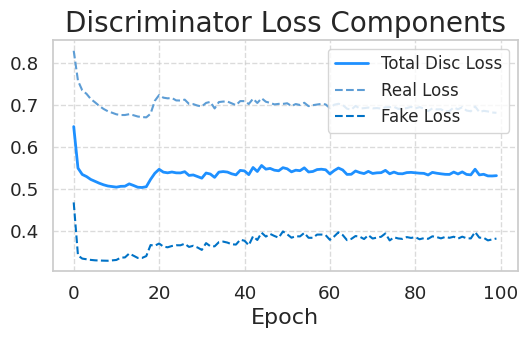

In [ ]:
# plt.figure(figsize=(12, 5))

# Left subplot - Generator loss components
plt.figure(figsize=(6, 3))
plt.plot(epoch_df['step'], epoch_df['g_loss'], label='Total Gen Loss', color='#e75480', linewidth=2)
plt.plot(epoch_df['step'], epoch_df['g_adv_loss'], label='Adversarial Loss', color='#ff9e9e', linewidth=1.5, linestyle='--')
plt.plot(epoch_df['step'], epoch_df['g_aux_loss'], label='Auxiliary Loss', color='#d64161', linewidth=1.5, linestyle='--')
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.ylabel('Loss Value', fontsize=16, fontfamily='sans-serif')
plt.title('Generator Loss Components', fontsize=20, fontfamily='sans-serif')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Right subplot - Discriminator loss components
plt.figure(figsize=(6, 3))
plt.plot(epoch_df['step'], epoch_df['d_loss'], label='Total Disc Loss', color='#1e90ff', linewidth=2)
plt.plot(epoch_df['step'], epoch_df['d_real_loss'], label='Real Loss', color='#5d9dd5', linewidth=1.5, linestyle='--')
plt.plot(epoch_df['step'], epoch_df['d_fake_loss'], label='Fake Loss', color='#0072c6', linewidth=1.5, linestyle='--')
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.title('Discriminator Loss Components', fontsize=20, fontfamily='sans-serif')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
plt.show()

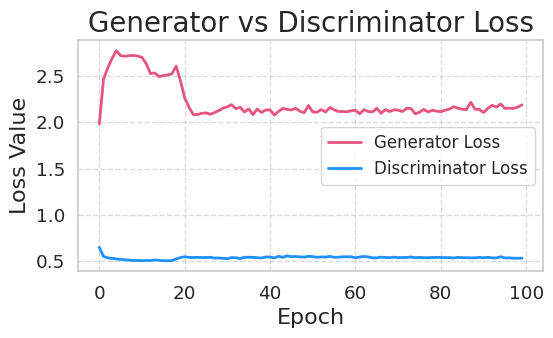

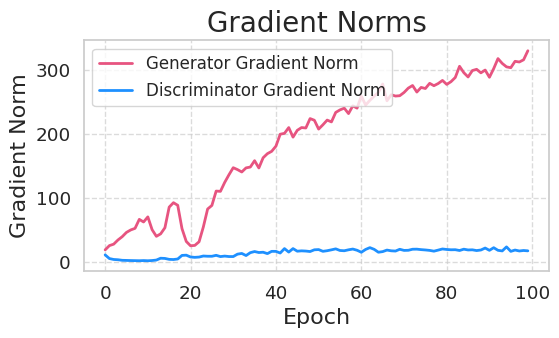

In [ ]:


# Left subplot - Main losses
plt.figure(figsize=(6, 3))
plt.plot(epoch_df['step'], epoch_df['g_loss'], label='Generator Loss', color='#e75480', linewidth=2)
plt.plot(epoch_df['step'], epoch_df['d_loss'], label='Discriminator Loss', color='#1e90ff', linewidth=2)
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.ylabel('Loss Value', fontsize=16, fontfamily='sans-serif')
plt.title('Generator vs Discriminator Loss', fontsize=20, fontfamily='sans-serif')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Right subplot - Gradient norms (to detect instability)
plt.figure(figsize=(6, 3))
plt.plot(epoch_df['step'], epoch_df['g_grad_norm'], label='Generator Gradient Norm', color='#e75480', linewidth=2)
plt.plot(epoch_df['step'], epoch_df['d_grad_norm'], label='Discriminator Gradient Norm', color='#1e90ff', linewidth=2)
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.ylabel('Gradient Norm', fontsize=16, fontfamily='sans-serif')
plt.title('Gradient Norms', fontsize=20, fontfamily='sans-serif')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# plt.tight_layout()
plt.show()

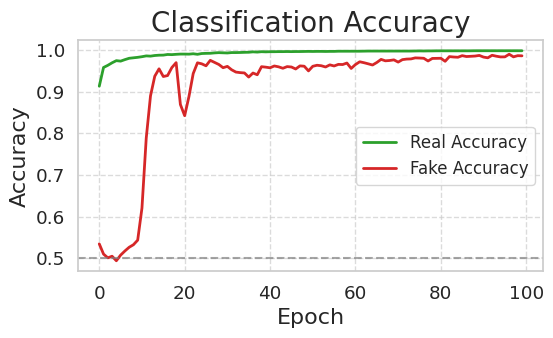

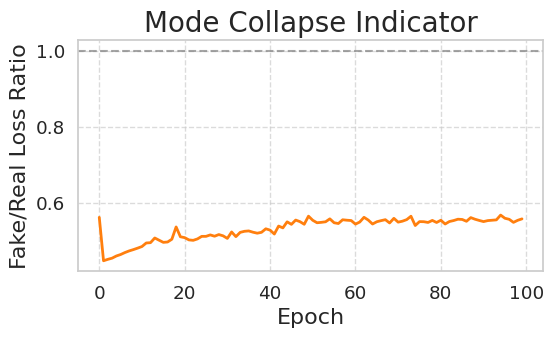

In [ ]:
# plt.figure(figsize=(12, 5))

# Left subplot - Real vs Fake accuracy
plt.figure(figsize=(6, 3))
plt.plot(epoch_df['step'], epoch_df['real_accuracy'], label='Real Accuracy', color='#2ca02c', linewidth=2)
plt.plot(epoch_df['step'], epoch_df['fake_accuracy'], label='Fake Accuracy', color='#d62728', linewidth=2)
# Add a reference line at 0.5
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.ylabel('Accuracy', fontsize=16, fontfamily='sans-serif')
plt.title('Classification Accuracy', fontsize=20, fontfamily='sans-serif')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Right subplot - Real vs Fake loss ratio (for mode collapse detection)
plt.figure(figsize=(6, 3))
# Calculate the ratio between fake and real losses
loss_ratio = epoch_df['d_fake_loss'] / epoch_df['d_real_loss']
plt.plot(epoch_df['step'], loss_ratio, color='#ff7f0e', linewidth=2)
plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.ylabel('Fake/Real Loss Ratio', fontsize=16, fontfamily='sans-serif')
plt.title('Mode Collapse Indicator', fontsize=20, fontfamily='sans-serif')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# plt.tight_layout()
# plt.show()

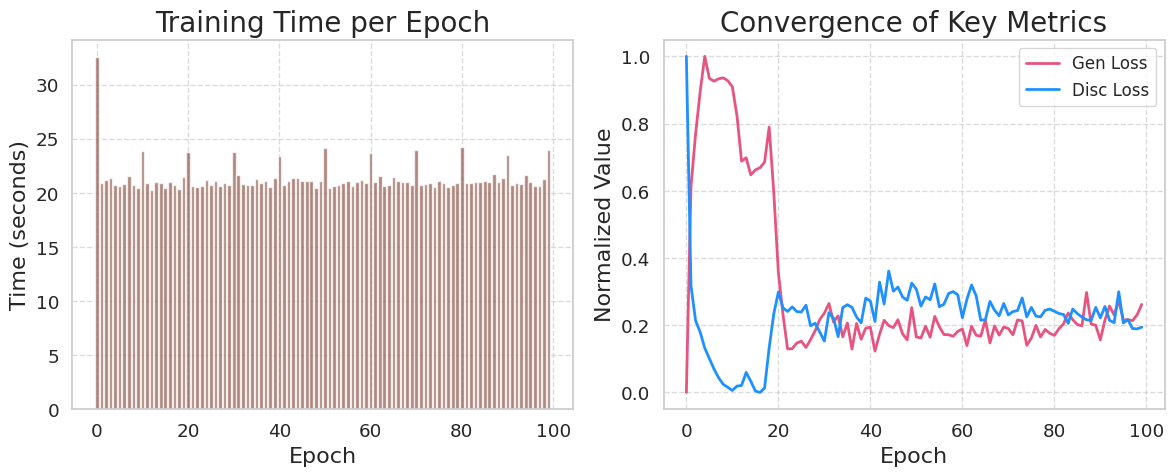

In [ ]:
plt.figure(figsize=(12, 5))

# Left subplot - Training time per epoch
plt.subplot(1, 2, 1)
plt.bar(epoch_df['step'], epoch_df['epoch_time'], color='#8c564b', alpha=0.7)
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.ylabel('Time (seconds)', fontsize=16, fontfamily='sans-serif')
plt.title('Training Time per Epoch', fontsize=20, fontfamily='sans-serif')
plt.grid(True, linestyle='--', alpha=0.7)

# Right subplot - Key metrics normalized
plt.subplot(1, 2, 2)
# Normalize FID and losses for comparison
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
metrics_to_normalize = ['g_loss', 'd_loss', 'fid_score']
normalized_df = pd.DataFrame(
    scaler.fit_transform(epoch_df[metrics_to_normalize]),
    columns=metrics_to_normalize
)
normalized_df['step'] = epoch_df['step']

plt.plot(normalized_df['step'], normalized_df['g_loss'], label='Gen Loss', color='#e75480', linewidth=2)
plt.plot(normalized_df['step'], normalized_df['d_loss'], label='Disc Loss', color='#1e90ff', linewidth=2)
# plt.plot(normalized_df['step'], normalized_df['fid_score'], label='FID Score', color='#9467bd', linewidth=2)
plt.xlabel('Epoch', fontsize=16, fontfamily='sans-serif')
plt.ylabel('Normalized Value', fontsize=16, fontfamily='sans-serif')
plt.title('Convergence of Key Metrics', fontsize=20, fontfamily='sans-serif')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()